# PROJET 7


# IMPLEMENTER UN MODELE DE SCORING


## NOTEBOOK 2 - MODELES DE CLASSIFICATION - ML FLOW

## 1.1. Import

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, ClusterCentroids,EditedNearestNeighbours, AllKNN, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline_imb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
import xgboost as xgb
import mlflow
from mlflow import log_metric, log_param, log_artifacts, log_metrics
from mlflow.models import infer_signature
from mlflow.sklearn import log_model
import os
import tempfile
import datetime
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import pickle
import yellowbrick
from yellowbrick import ROCAUC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

#### Mise en place environnement

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
DISPLAY=True

In [9]:
from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN="2YUPWBbQP1tmCPTg1x2qVsxinj7_6j69afS3SEA4Y8fBPTCmM"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel=ngrok.connect(addr="5000",proto="http",bind_tls=True)
print("MLFLOW Tracking UI :", ngrok_tunnel.public_url)

t=2024-04-08T08:23:27+0200 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=C:\\Users\\helen\\AppData\\Local/ngrok/ngrok.yml legacy_path=C:\\Users\\helen\\.ngrok2\\ngrok.yml


MLFLOW Tracking UI : https://dd69-156-200-103-3.ngrok-free.app


In [10]:
!mlflow ui

^C


## PARTIE 1 - JEU DE DONNEES & BASELINE

## 1.1 Import

In [11]:
data_train=pd.read_csv('data_work/data_train.csv', sep ='\t')

In [12]:
data_train.shape

(307511, 95)

In [13]:
data_train.head()

,Unnamed: 0,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,APARTMENTS_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,LANDAREA_MODE,LIVINGAREA_MODE,YEARS_BEGINEXPLUATATION_MEDI,LIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,PREVIOUS_LOANS_COUNT,DAYS_CREDIT_ENDDATE,AMT_CREDIT_SUM_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,MONTHS_BALANCE,STATUS,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,PREV_APPL_MEAN_CARD_MEAN_SK_DPD,PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,TARGET,SK_ID_CURR
0,0,Cash loans,M,N,202500.0,406597.5,24700.5,351000.0,Working,Secondary / secondary special,Single / not married,0.018801,25.920548,1.745205,9.994521,5.808219,9.0,0.0,Laborers,2.0,WEDNESDAY,10.0,0.0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0369,0.9722,0.6192,0.0143,0.0690,0.0833,0.0369,0.0202,0.0252,0.9722,0.0144,0.0377,0.0198,0.9722,0.0193,0.0149,2.0,2.0,2.0,3.106849,1.0,0.0,0.0,1.0,8.0,0.956164,0.0,865055.565,245781.0,-15.5,4.5,1.0,9251.775,179055.00,0.00,9.000000,0.000000,1.660274,500.000000,24.000000,-1000.665753,1.547945,-0.342466,0.068493,0.046575,0.000000,-10.0,160714.285714,1486.046512,0.0,4343.023256,26341.468354,0.078947,0.0,3.0,0.0,0.0,1.052632,10.000000,0.808219,11559.247105,11559.247105,2.007889,0.121978,16.461104,0.067329,1.0,100002.0
1,1,Cash loans,F,N,270000.0,1293502.5,35698.5,1129500.0,State servant,Higher education,Married,0.003541,45.931507,3.254795,3.249315,0.797260,9.0,0.0,Core staff,1.0,MONDAY,11.0,0.0,School,0.311267,0.622246,0.533482,0.0529,0.9851,0.7960,0.0605,0.0345,0.2917,0.0130,0.0773,0.0924,0.9851,0.0497,0.0128,0.0554,0.9851,0.0558,0.0714,1.0,0.0,0.0,2.268493,1.0,0.0,0.0,0.0,4.0,1.491781,0.0,1017400.500,0.0,0.0,8.0,3.0,56553.990,484191.00,3442.50,14.666667,0.050030,3.575342,533.000000,10.000000,-1000.665753,3.491324,2.751598,2.888584,2.869406,0.666667,-10.0,160714.285714,1486.046512,0.0,4343.023256,26341.468354,0.078947,0.0,3.0,0.0,0.0,1.047619,4.666667,3.189954,78558.479286,78558.479286,4.790750,0.132217,36.234085,0.070862,0.0,100003.0
2,2,Revolving loans,M,Y,67500.0,135000.0,6750.0,135000.0,Working,Secondary / secondary special,Single / not married,0.010032,52

In [14]:
data_train=data_train.sample(frac=0.4)
data_train.shape

(123004, 95)

In [15]:
X=data_train.drop(['SK_ID_CURR','TARGET','Unnamed: 0'],axis=1)
X.shape

(123004, 92)

In [16]:
y=data_train['TARGET']
y.shape

(123004,)

In [17]:
num_feat=X.select_dtypes(exclude=object).columns.to_list()
num_feat

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'COMMONAREA_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'PREVIOUS_LOANS_COUNT',
 'DAYS_CREDIT_ENDDATE',
 'AMT_CREDIT_SUM_OVER

In [18]:
cat_feat=X.select_dtypes(include=object).columns.to_list()
cat_feat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [19]:
X.shape

(123004, 92)

### 1 - 1 Séparation du jeu de données

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [21]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (98403, 92)
Test set: (24601, 92)
Train target: (98403,)
Test target: (24601,)


In [22]:
def Score_metier(y_true, y_pred):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp + tn - fp -10* fn
    
    # Gain maximum
    max_J = (fp + tn) + (fn + tp)
    
    # Gain minimum
    min_J = -(fp + tn) -10* (fn + tp)
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

### 1 - 2  Baseline avec Dummyclassifier

In [23]:
Baseline=DummyClassifier()

In [24]:
Baseline.fit(X_train,y_train)

DummyClassifier()

In [25]:
Baseline_pred=Baseline.predict(X_test)

In [26]:
roc_auc = roc_auc_score(y_test, Baseline.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, Baseline.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     22591
         1.0       0.00      0.00      0.00      2010

    accuracy                           0.92     24601
   macro avg       0.46      0.50      0.48     24601
weighted avg       0.84      0.92      0.88     24601



In [27]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):

    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
        for i in range(20):
            features.append(X_train.columns[indices[i]])

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)

        show()

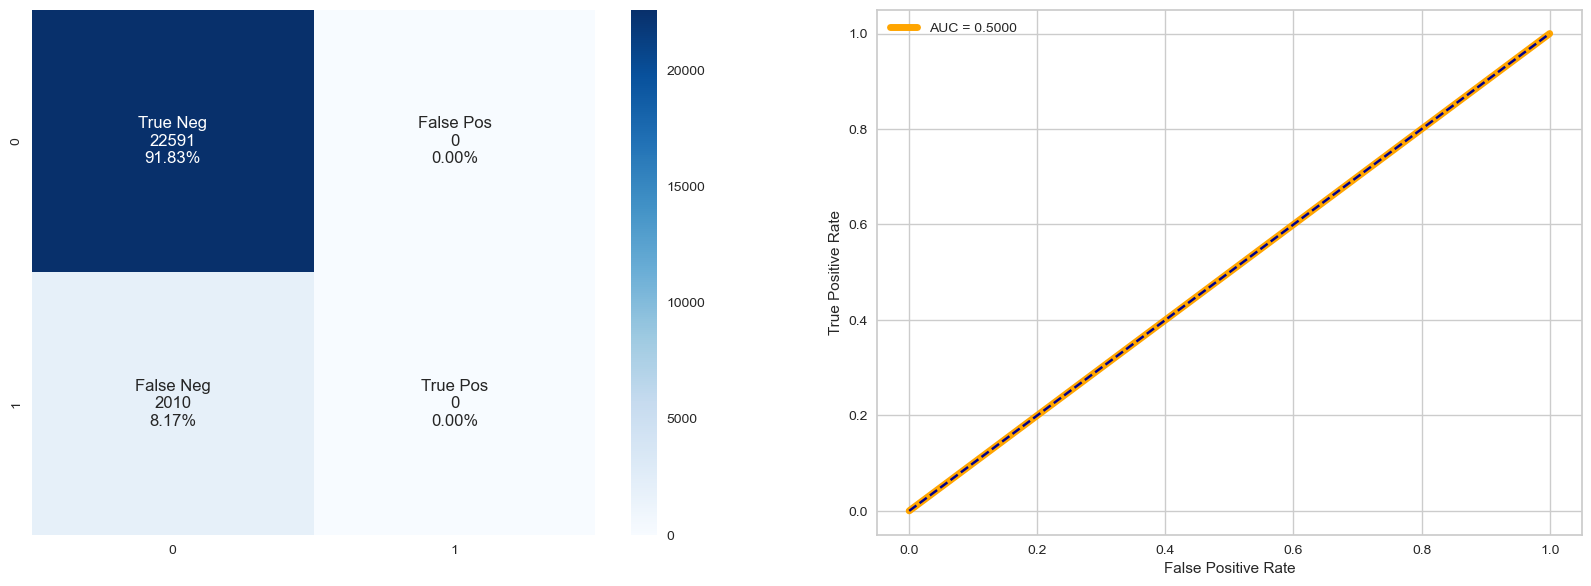

In [28]:
cf_matrix_roc_auc(Baseline, y_test, Baseline.predict(X_test), Baseline.predict_proba(X_test)[:,1], feature_importances=None)

### 1 - 3  Log ML FLOW

In [29]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

run_id=c2e8de9d312d4a158e123c1eba50b938


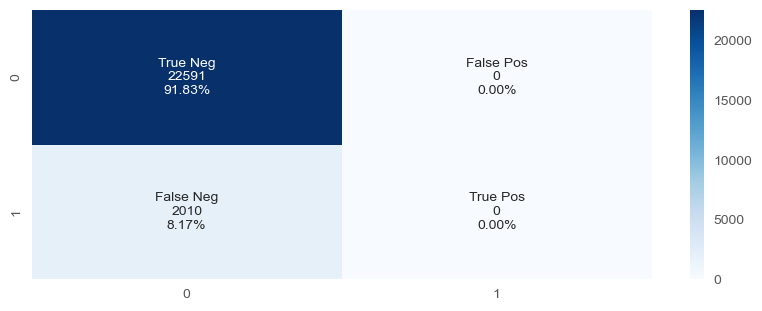

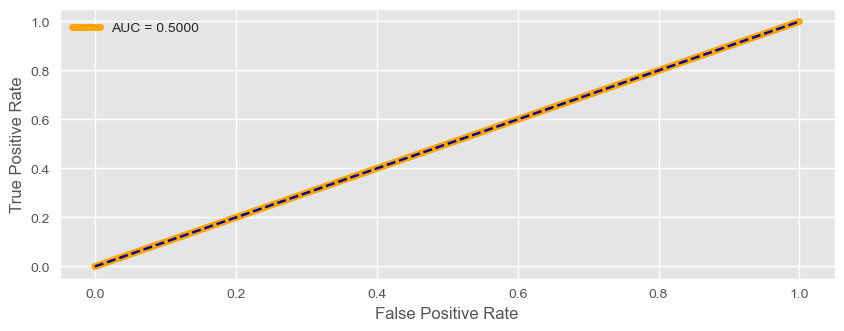

In [31]:
plt.style.use('ggplot')

experiment_name = 'Baseline - Dummy Classifier'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
#mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.sklearn.autolog()

col = 0

with mlflow.start_run(run_name='Baseline - Dummy Classifier') as run:
    model = DummyClassifier()
    model.fit(X_train, y_train)
        
    signature = infer_signature(X_train, model.predict(X_train))

        
    mlflow.sklearn.log_model(model, 'model', signature=signature)

    preds = model.predict_proba(X_train)[:,1]

    fpr, tpr, thresholds = roc_curve(y_train, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
        
    y_test_pred = [1 if i >= optimal_threshold else 0 for i in model.predict_proba(X_test)[:,1]]   
    y_train_pred = [1 if i >= optimal_threshold else 0 for i in model.predict_proba(X_train)[:,1]]          
        
        
    # Calcul des métriques techniques et métrique métier
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)

    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
        
        
    y_train_prob = model.predict_proba(X_train)[:,1]
    y_test_prob = model.predict_proba(X_test)[:,1]

    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)
        
        
    Score_metier_train=Score_metier(y_train, y_train_pred)
    Score_metier_test=Score_metier(y_test, y_test_pred)
        
        
    perf_metrics = {         
    'precision_train': precision_train,
    'precision_val': precision_test,
    'recall_train': recall_train,
    'recall_val': recall_test,
    'f1_train': f1_train,
    'f1_val': f1_test,            
    'auc_train': auc_train,
    'auc_val': auc_test,
    'Score_metier_train':Score_metier_train,
    'Score_metier_test':Score_metier_test,  
    'solvability_threshold':optimal_threshold}
    mlflow.log_metrics(perf_metrics)

        # Matrice de confusion"
    fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    mlflow.log_figure(fig, 'fig/02-Matrice de confusion.png')
        
        
        # Courbe ROC AUC
    fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
    fpr,tpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_test)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    mlflow.log_figure(fig, 'fig/01-ROC AUC.png')
        

    run_id = mlflow.active_run().info.run_id
    print(f'run_id={run_id}')


## PARTIE 2 - MODELES DE CLASSIFICATION

### 2 - 1 Test sur différents Modèles

In [32]:
transformer=ColumnTransformer(transformers=
                              [
                               ('OneHot',OneHotEncoder(sparse=False,handle_unknown='ignore'),cat_feat),
                               ],
                               remainder='passthrough'
                             )
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                  'FLAG_OWN_CAR', 'NAME_INCOME_TYPE',
                                  'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                  'OCCUPATION_TYPE',
                                  'WEEKDAY_APPR_PROCESS_START',
                                  'ORGANIZATION_TYPE'])])

In [33]:
pipeline=Pipeline_imb([
    ('transformer',transformer),
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('sampler',RandomUnderSampler()),
    ('estimator',LogisticRegression())
])
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('sampler', RandomUnderSampler()),
                ('estimator', LogisticRegression())])

In [34]:
param_grid={
    'sampler':[RandomUnderSampler()],
    'transformer':[transformer,'passthrough'],
    'scaler':[StandardScaler(),'passthrough'], 
    'estimator':[KNeighborsClassifier(),LogisticRegression(),LGBMClassifier()]
}

In [35]:
scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'f1': 'f1',
        'recall':'recall',
        'precision':'precision',
        'score_metier': (make_scorer(Score_metier,))# greater_is_better=False,))
}

In [36]:
grid= GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [37]:
if DISPLAY:
    grid.fit(X,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 9969, number of negative: 9969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15957
[LightGBM] [Info] Number of data points in the train set: 19938, number of used features: 174
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [38]:
resultat = pd.DataFrame(grid.cv_results_).round(2)
cols = [i for i in resultat.columns if 'split' not in i ]
resultat = resultat.loc[:,cols].sort_values(by='mean_test_roc_auc',ascending=False).head(10)
resultat

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_sampler,param_scaler,param_transformer,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_score_metier,std_test_score_metier,rank_test_score_metier,mean_train_score_metier,std_train_score_metier
8,127.43,1.40,0.87,0.17,LGBMClassifier(),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(), 'sampler': Ran...",0.76,0.01,2,0.84,0.0,0.69,0.00,2,0.72,0.00,0.27,0.01,2,0.32,0.0,0.69,0.02,2,0.82,0.00,0.17,0.0,2,0.20,0.0,0.69,0.01,2,0.74,0.0
10,38.71,36.88,0.71,0.03,LGBMClassifier(),RandomUnderSampler(),passthrough,"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(), 'sampler': Ran...",0.76,0.01,1,0.84,0.0,0.69,0.00,1,0.71,0.00,0.27,0.01,1,0.32,0.0,0.70,0.02,1,0.82,0.00,0.17,0.0,1,0.20,0.0,0.69,0.00,1,0.74,0.0
4,11.58,1.22,1.95,0.11,LogisticRegression(),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LogisticRegression(), 'sampler':...",0.75,0.01,3,0.76,0.0,0.69,0.00,3,0.69,0.00,0.26,0.00,3,0.27,0.0,0.68,0.01,3,0.69,0.00,0.16,0.0,3,0.17,0.0,0.69,0.00,3,0.69,0.0
6,8.42,0.51,1.45,0.31,LogisticRegression(),RandomUnderSampler(),passthrough,"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LogisticRegression(), 'sampler':...",0.62,0.00,4,0.62,0.0,0.63,0.01,4,0.63,0.01,0.19,0.00,4,0.19,0.0,0.54,0.02,5,0.54,0.01,0.12,0.0,4,0.12,0.0,0.60,0.00,4,0.60,0.0
0,9.23,0.65,37.92,2.14,KNeighborsClassifier(),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': KNeighborsClassifier(), 'sampler...",0.61,0.01,5,0.71,0.0,0.58,0.01,5,0.61,0.00,0.18,0.00,5,0.23,0.0,0.58,0.01,4,0.73,0.01,0.11,0.0,5,0.14,0.0,0.58,0.01,5,0.64,0.0
2,7.34,0.53,38.27,2.17,KNeighborsClassifier(),RandomUnderSampler(),passthrough,"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': KNeighborsClassifier(), 'sampler...",0.56,0.01,6,0.68,0.0,0.55,0.01,6,0.58,0.00,0.16,0.00,6,0.22,0.0,0.54,0.01,6,0.71,0.00,0.10,0.0,6,0.13,0.0,0.55,0.00,6,0.61,0.0
1,2.21,0.27,0.00,0.00,KNeighborsClassifier(),RandomUnderSampler(),StandardScaler(),passthrough,"{'estimator': KNeighborsClassifier(), 'sampler...",NaN,NaN,7,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,7,NaN,NaN
3,3.16,0.88,0.00,0.00,KNeighborsClassifier(),RandomUnderSampler(),passthrough,passthrough,"{'estimator': KNeighborsClassifier(), 'sampler...",NaN,NaN,8,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,8,NaN,NaN
5,1.75,0.25,0.00,0.00,LogisticRegression(),RandomUnderSampler(),StandardScaler(),passthrough,"{'estimator': LogisticRegression(), 'sampler':...",NaN,NaN,9,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,9,NaN,NaN
7,1.64,0.17,0.00,0.00,LogisticRegression(),RandomUnderSampler(),passthrough,passthrough,"{'estimator': LogisticRegression(), 'sampler':...",NaN,NaN,10,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,10,NaN,NaN


In [39]:
grid.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE'])])),
                ('imputer', SimpleImputer()), ('scaler', 'passthrough'),
                ('sampler', RandomUnderSampler()),
                ('estimator', LGBMClassifier())])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 7959, number of negative: 7959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15810
[LightGBM] [Info] Number of data points in the train set: 15918, number of used features: 173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
run_id=3206657ae42a418e98c5e440e36a2d9e


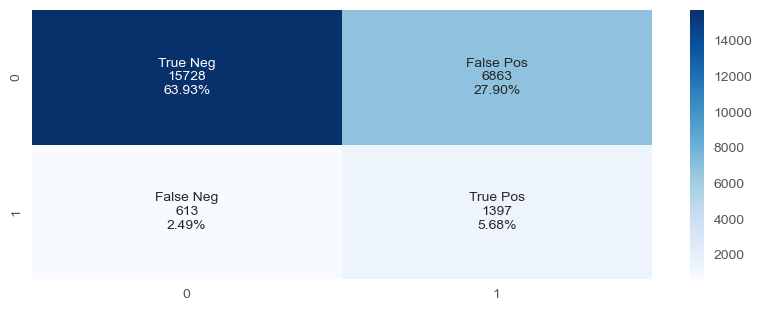

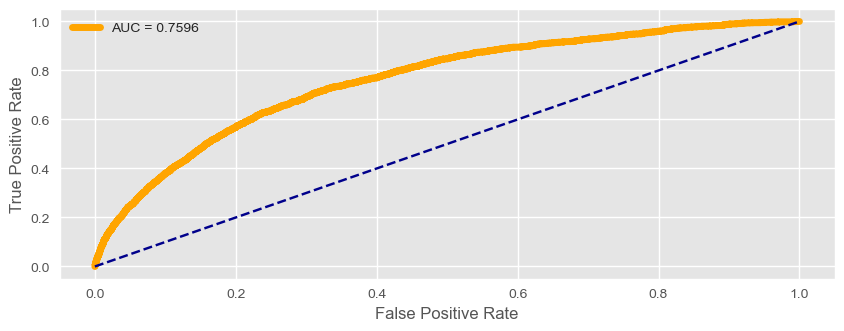

In [40]:
plt.style.use('ggplot')

experiment_name = 'Modèles (KNN-LogReg-LGBM)'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
#mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.sklearn.autolog()

col = 0

with mlflow.start_run(run_name='Modèles (KNN-LogReg-LGBM)') as run:
    model = grid
    model.fit(X_train, y_train)
        
    signature = infer_signature(X_train, model.predict(X_train))

        
    mlflow.sklearn.log_model(model, 'model', signature=signature)
    mlflow.log_params(model.best_params_)

        
    best_model = model.best_estimator_
    preds = best_model.predict_proba(X_train)[:,1]

    fpr, tpr, thresholds = roc_curve(y_train, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
        
    y_test_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_test)[:,1]]   
    y_train_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_train)[:,1]]          
        
        
    # Calcul des métriques techniques et métrique métier
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)

    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
        
        
    y_train_prob = model.predict_proba(X_train)[:,1]
    y_test_prob = model.predict_proba(X_test)[:,1]

    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)
        
        
    Score_metier_train=Score_metier(y_train, y_train_pred)
    Score_metier_test=Score_metier(y_test, y_test_pred)
        
        
    perf_metrics = {         
    'precision_train': precision_train,
    'precision_val': precision_test,
    'recall_train': recall_train,
    'recall_val': recall_test,
    'f1_train': f1_train,
    'f1_val': f1_test,            
    'auc_train': auc_train,
    'auc_val': auc_test,
    'Score_metier_train':Score_metier_train,
    'Score_metier_test':Score_metier_test,  
    'solvability_threshold':optimal_threshold}
    mlflow.log_metrics(perf_metrics)

    pd.DataFrame({k: model.cv_results_[k] for k in model.cv_results_ if k not in {'params'}}) \
         .to_csv('./Stockage MLFLOW/cv-results.csv', index=False)
    mlflow.log_artifact('./Stockage MLFLOW/cv-results.csv', 'artifact')

        # Matrice de confusion"
    fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    mlflow.log_figure(fig, 'fig/02-Matrice de confusion.png')
        
        
        # Courbe ROC AUC
    fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
    fpr,tpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_test)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    mlflow.log_figure(fig, 'fig/01-ROC AUC.png')
        

    run_id = mlflow.active_run().info.run_id
    print(f'run_id={run_id}')


In [41]:
grid.best_params_

{'estimator': LGBMClassifier(),
 'sampler': RandomUnderSampler(),
 'scaler': 'passthrough',
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('OneHot',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                   'FLAG_OWN_CAR', 'NAME_INCOME_TYPE',
                                   'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                   'OCCUPATION_TYPE',
                                   'WEEKDAY_APPR_PROCESS_START',
                                   'ORGANIZATION_TYPE'])])}

### 2 - 2  Améliorations hyperparamètres & Seuil de probabilité - LGBM

In [42]:
best_LGBM=Pipeline_imb([
    ('transformer',transformer),
    ('imputer',SimpleImputer(strategy='median')), 
    ('scaler',StandardScaler()),    
    ('sampler', RandomUnderSampler()),
    ('estimator',LGBMClassifier())
])
best_LGBM

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE'])])),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('sampler', RandomUnderSampler()),
                ('estimator', LGBMClassifier())])

In [43]:
param_grid={
    'transformer':[transformer,'passthrough'],
    'imputer':[SimpleImputer(strategy='median')],    
    'sampler':[ RandomUnderSampler()],
    'scaler':[StandardScaler()],
    'estimator':[LGBMClassifier()],
    'estimator__num_leaves':[20,25,31],
    'estimator__max_depth':[3],
    'estimator__min_data_in_leaf':[500,750,1000]
}

In [44]:
grid= GridSearchCV(
    best_LGBM,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
    refit='roc_auc')

In [45]:
if DISPLAY:
    grid.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 7959, number of negative: 7959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15251
[LightGBM] [Info] Number of data points in the train set: 15918, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [46]:
resultat = pd.DataFrame(grid.cv_results_).round(2)
cols = [i for i in resultat.columns if 'split' not in i ]
resultat = resultat.loc[:,cols].sort_values(by='mean_test_roc_auc',ascending=False).head(10)
resultat

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__max_depth,param_estimator__min_data_in_leaf,param_estimator__num_leaves,param_imputer,param_sampler,param_scaler,param_transformer,params,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,mean_train_roc_auc,std_train_roc_auc,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_train_accuracy,std_train_accuracy,mean_test_f1,std_test_f1,rank_test_f1,mean_train_f1,std_train_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_train_recall,std_train_recall,mean_test_precision,std_test_precision,rank_test_precision,mean_train_precision,std_train_precision,mean_test_score_metier,std_test_score_metier,rank_test_score_metier,mean_train_score_metier,std_train_score_metier
0,29.32,2.35,1.20,0.22,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,500,20,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,4,0.77,0.0,0.69,0.00,8,0.69,0.0,0.27,0.0,1,0.28,0.0,0.70,0.01,1,0.72,0.0,0.17,0.0,3,0.17,0.0,0.69,0.0,3,0.7,0.0
2,27.75,4.67,0.83,0.30,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,500,25,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,2,0.78,0.0,0.69,0.01,3,0.70,0.0,0.27,0.0,5,0.28,0.0,0.69,0.01,6,0.72,0.0,0.16,0.0,5,0.17,0.0,0.69,0.0,5,0.7,0.0
4,34.68,8.86,0.81,0.45,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,500,31,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,1,0.77,0.0,0.69,0.00,9,0.69,0.0,0.27,0.0,8,0.28,0.0,0.69,0.01,4,0.72,0.0,0.16,0.0,8,0.17,0.0,0.69,0.0,8,0.7,0.0
6,32.76,4.05,0.66,0.07,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,750,20,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,6,0.77,0.0,0.69,0.00,1,0.70,0.0,0.27,0.0,2,0.27,0.0,0.69,0.01,7,0.71,0.0,0.17,0.0,1,0.17,0.0,0.69,0.0,1,0.7,0.0
8,26.19,4.55,0.82,0.22,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,750,25,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,5,0.77,0.0,0.69,0.00,2,0.70,0.0,0.27,0.0,4,0.28,0.0,0.69,0.01,8,0.71,0.0,0.17,0.0,4,0.17,0.0,0.69,0.0,4,0.7,0.0
10,31.59,2.88,0.66,0.27,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,750,31,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,3,0.77,0.0,0.69,0.01,7,0.69,0.0,0.27,0.0,6,0.27,0.0,0.69,0.01,3,0.72,0.0,0.16,0.0,6,0.17,0.0,0.69,0.0,6,0.7,0.0
14,22.79,0.62,0.62,0.11,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,1000,25,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,7,0.77,0.0,0.69,0.00,4,0.69,0.0,0.27,0.0,3,0.27,0.0,0.70,0.01,2,0.71,0.0,0.17,0.0,2,0.17,0.0,0.69,0.0,2,0.7,0.0
16,15.65,2.69,0.71,0.09,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,1000,31,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remainder='passthrough',\n ...","{'estimator': LGBMClassifier(max_depth=3, min_...",0.76,0.0,8,0.77,0.0,0.69,0.01,6,0.69,0.0,0.27,0.0,7,0.27,0.0,0.69,0.01,5,0.71,0.0,0.16,0.0,7,0.17,0.0,0.69,0.0,7,0.7,0.0
12,28.50,1.11,0.76,0.17,"LGBMClassifier(max_depth=3, min_data_in_leaf=500)",3,1000,20,SimpleImputer(strategy='median'),RandomUnderSampler(),StandardScaler(),"ColumnTransformer(remaind

In [47]:
grid.best_params_

{'estimator': LGBMClassifier(max_depth=3, min_data_in_leaf=500),
 'estimator__max_depth': 3,
 'estimator__min_data_in_leaf': 500,
 'estimator__num_leaves': 31,
 'imputer': SimpleImputer(strategy='median'),
 'sampler': RandomUnderSampler(),
 'scaler': StandardScaler(),
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('OneHot',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                   'FLAG_OWN_CAR', 'NAME_INCOME_TYPE',
                                   'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                                   'OCCUPATION_TYPE',
                                   'WEEKDAY_APPR_PROCESS_START',
                                   'ORGANIZATION_TYPE'])])}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Info] Number of positive: 7959, number of negative: 7959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14832
[LightGBM] [Info] Number of data points in the train set: 15918, number of used features: 112
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

run_id=b1a04adcae0c4b569b54d2e44a6d2586


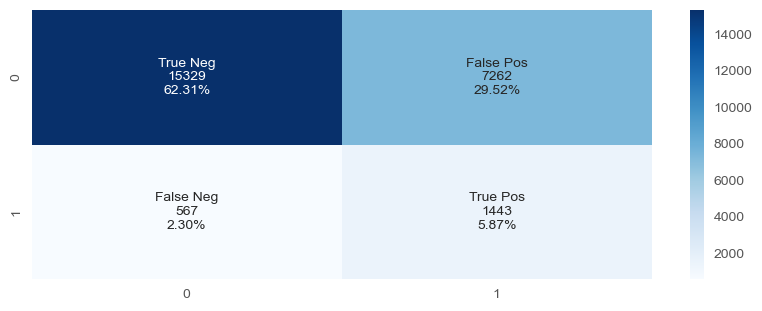

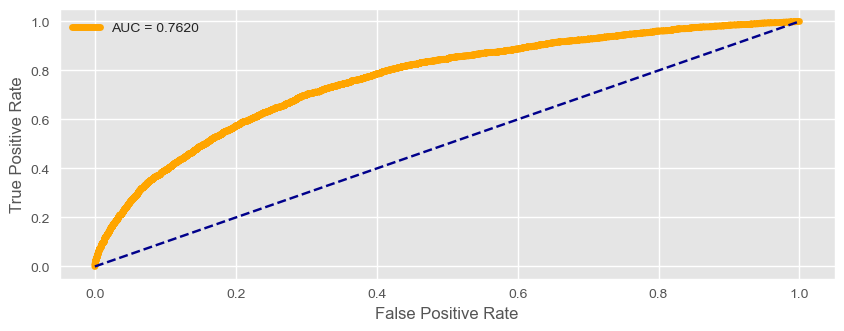

In [48]:
plt.style.use('ggplot')

experiment_name = 'Hyperparametres - LGBM'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
#mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
#mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)
#mlflow.sklearn.autolog()

col = 0

with mlflow.start_run(run_name='Hyperparametres - LGBM') as run:
    model = grid
    model.fit(X_train, y_train)
        
    signature = infer_signature(X_train, model.predict(X_train))

        
    mlflow.sklearn.log_model(model, 'model', signature=signature)
    mlflow.log_params(model.best_params_)

        
    best_model = model.best_estimator_
    preds = best_model.predict_proba(X_train)[:,1]

    fpr, tpr, thresholds = roc_curve(y_train, preds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
        
    y_test_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_test)[:,1]]   
    y_train_pred = [1 if i >= optimal_threshold else 0 for i in best_model.predict_proba(X_train)[:,1]]          
        
        
    # Calcul des métriques techniques et métrique métier
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)

    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)

    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)
        
        
    y_train_prob = model.predict_proba(X_train)[:,1]
    y_test_prob = model.predict_proba(X_test)[:,1]

    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)
        
        
    Score_metier_train=Score_metier(y_train, y_train_pred)
    Score_metier_test=Score_metier(y_test, y_test_pred)
        
        
    perf_metrics = {         
    'precision_train': precision_train,
    'precision_val': precision_test,
    'recall_train': recall_train,
    'recall_val': recall_test,
    'f1_train': f1_train,
    'f1_val': f1_test,            
    'auc_train': auc_train,
    'auc_val': auc_test,
    'Score_metier_train':Score_metier_train,
    'Score_metier_test':Score_metier_test,  
    'solvability_threshold':optimal_threshold}
    mlflow.log_metrics(perf_metrics)

    pd.DataFrame({k: model.cv_results_[k] for k in model.cv_results_ if k not in {'params'}}) \
         .to_csv('./Stockage MLFLOW/cv-results.csv', index=False)
    mlflow.log_artifact('./Stockage MLFLOW/cv-results.csv', 'artifact')

        # Matrice de confusion"
    fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    mlflow.log_figure(fig, 'fig/02-Matrice de confusion.png')
        
        
        # Courbe ROC AUC
    fig, ax = plt.subplots(1,1, figsize=(10, 3.5))
    fpr,tpr,_ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %auc_test)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    mlflow.log_figure(fig, 'fig/01-ROC AUC.png')
        

    run_id = mlflow.active_run().info.run_id
    print(f'run_id={run_id}')


In [49]:
pickle_out = open("best_lgbm.pkl","wb")
pickle.dump(best_LGBM, pickle_out)
pickle_out.close()